In [1]:
 from google.colab import files
 uploaded = files.upload()

Saving processed_data.csv to processed_data.csv


## Load Data

In [6]:
# (Egyptian)  EG (0) ==> EG
# (Magharbi)  MA (1) ==> TN - LY - DZ - MA
# (gulf)      GU (2) ==> BH - QA - KW - OM - AE - SA - YE
# (Levantine) LE (3) ==> JO - LB - PL - SY
# (Others)    TH (4) ==> SD - IQ
import pandas as pd
data = pd.read_csv('processed_data.csv')
print(data.shape)
data.head()

(458196, 4)


,id,text,dialect,processed_text
0,1130199209695744000,الاقيش معاك 25 الف يا عم نجيب قرض حسن ابدا بيه...,0,الاقيش معاك الف يا عم نجيب قرض حسن ابدا بيهم ح...
1,1137520472420233216,@khbondok4 وهو انت لو بتفهم كنت بقيت زملكاوي ؟!,0,وهو انت لو بتفهم كنت بقيت زملكاوي
2,1137717993172033536,@aelnagar5 @khbondok4 ولولوا عليك ساعة وسكتوا,0,ولولوا عليك ساعه وسكتوا
3,1137810705514684416,@aelnagar5 @Lokareta2 لا ساعة واحدة عشان بواب ...,0,لا ساعه واحده عشان بواب ملكش عازه
4,1125394999997284352,@TurkiHAlhamad1 جنسيتك ايه ؟\nده انت لو صهيوني...,0,جنسيتك ايه ده انت لو صهيوني مش هتقول كده


## Split data

In [7]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

X = data['processed_text']
y = data['dialect']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Methods we will use

### report method to see our model

In [8]:
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report

def report(model, X_train,X_test, y_train, y_test):
  train_acc = model.score(X_train, y_train)   # to see train accuracy
  test_acc = model.score(X_test, y_test)    # to see test accuracy
  print(f'Train acc: {train_acc}')
  print(f'Test acc: {test_acc}')

  predictions=model.predict(X_test)    # this is predictions
  cr = classification_report(predictions,y_test)  # to see precision and recall and f1_score for each label 
  print(cr)
 
  fig, ax = plt.subplots(figsize=(6, 6))  
  plot_confusion_matrix(model, X_test, y_test, ax=ax)  # to plot predictions
  plt.show()

### text_fit_predict method to fit our model with processed data

In [9]:
# this method to fit our orignal data
def text_fit_predict(X_train, X_test, y_train, y_test, model_model):

  model = model_model.fit(X_train, y_train)  # fit our model
  report(model, X_train,X_test, y_train, y_test)

  return model

## Build classification models


### Build models with CountVectorizer 

Train acc: 0.8114612774037255
Test acc: 0.757158446093409
              precision    recall  f1-score   support

           0       0.71      0.80      0.75     10326
           1       0.60      0.81      0.69     10820
           2       0.92      0.73      0.81     45826
           3       0.72      0.77      0.75     21670
           4       0.40      0.80      0.53      2998

    accuracy                           0.76     91640
   macro avg       0.67      0.78      0.71     91640
weighted avg       0.79      0.76      0.77     91640



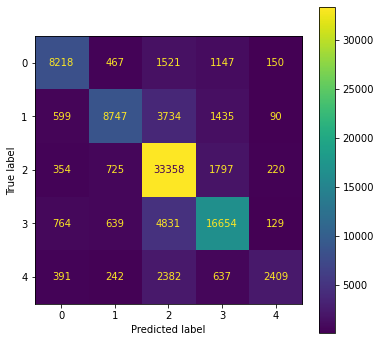

In [10]:
import arabicstopwords.arabicstopwords as stp   # to remove arabic stop words
from sklearn.linear_model import LogisticRegression  # our model used solver 'sag' because our data is large
from sklearn.feature_extraction.text import CountVectorizer # type of feature_extraction

cntVec = CountVectorizer(stop_words = stp.STOPWORDS)
X_train_c = cntVec.fit_transform(X_train)  # fit X_train only
X_test_c = cntVec.transform(X_test)  # transform X_test
model1 = text_fit_predict(X_train_c, X_test_c, y_train, y_test, LogisticRegression(solver='sag'))

### Build models with TfidfVectorizer

Train acc: 0.841803162409018
Test acc: 0.766281099956351
              precision    recall  f1-score   support

           0       0.74      0.79      0.76     10803
           1       0.62      0.82      0.71     11069
           2       0.92      0.74      0.82     45305
           3       0.73      0.78      0.75     21536
           4       0.39      0.81      0.52      2927

    accuracy                           0.77     91640
   macro avg       0.68      0.79      0.71     91640
weighted avg       0.80      0.77      0.77     91640



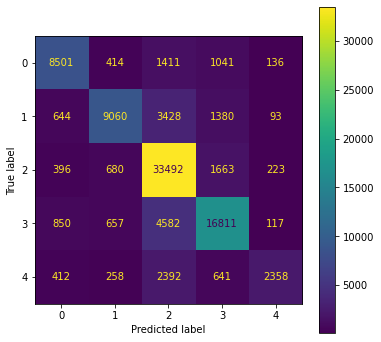

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer  # feature_extraction

tfidf = TfidfVectorizer(stop_words = stp.STOPWORDS)  # stp.STOPWORDS ==> arabic stop words
X_train_tfidf = tfidf.fit_transform(X_train)  # fit X_train only
X_test_tfidf = tfidf.transform(X_test) # transform X_test
model2 = text_fit_predict(X_train_tfidf, X_test_tfidf, y_train, y_test, LogisticRegression(solver='sag'))

## Build Deep learning model

### convert labels

In [13]:
dict = { 0:'EG', 1:'MG', 2:'GU', 3:'LE', 4:'TH'}
data['dialect'] = data['dialect'].map(dict)

### Build tokenizer

In [23]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each text. (make it 150)
MAX_SEQUENCE_LENGTH = 30

EMBEDDING_DIM = 30

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['processed_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 429893 unique tokens.


In [24]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(data['processed_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(data['dialect']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (458196, 30)
Shape of label tensor: (458196, 5)


### Split data

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(366556, 30) (366556, 5)
(91640, 30) (91640, 5)


### Build & Train deep learning model with four layers

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Dense(64, activation='relu'))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 30)            1500000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 30, 30)           0         
 lDropout1D)                                                     
                                                                 
 dense_8 (Dense)             (None, 30, 64)            1984      
                                                                 
 lstm_1 (LSTM)               (None, 100)               66000     
                                                                 
 dense_9 (Dense)             (None, 64)                6464      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [30]:
from keras.callbacks import EarlyStopping

epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.25,
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0001)])

Epoch 1/20
4296/4296 [==============================] - 424s 99ms/step - loss: 0.6879 - accuracy: 0.7772 - val_loss: 0.6912 - val_accuracy: 0.7644
Epoch 2/20
4296/4296 [==============================] - 415s 97ms/step - loss: 0.6303 - accuracy: 0.7967 - val_loss: 0.7067 - val_accuracy: 0.7673
Epoch 3/20
4296/4296 [==============================] - 415s 97ms/step - loss: 0.5868 - accuracy: 0.8114 - val_loss: 0.7081 - val_accuracy: 0.7664
Epoch 4/20
4296/4296 [==============================] - 416s 97ms/step - loss: 0.5527 - accuracy: 0.8208 - val_loss: 0.7373 - val_accuracy: 0.7662
Epoch 5/20
4296/4296 [==============================] - 415s 97ms/step - loss: 0.5269 - accuracy: 0.8284 - val_loss: 0.7728 - val_accuracy: 0.7626
Epoch 6/20
4296/4296 [==============================] - 416s 97ms/step - loss: 0.5075 - accuracy: 0.8351 - val_loss: 0.8045 - val_accuracy: 0.7622
Epoch 7/20
4296/4296 [==============================] - 417s 97ms/step - loss: 0.4868 - accuracy: 0.8406 - val_loss: 0

In [31]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2864/2864 [==============================] - 27s 10ms/step - loss: 0.8449 - accuracy: 0.7596
Test set
  Loss: 0.845
  Accuracy: 0.760


## Save models using pickle

In [32]:
import pickle
filename = 'DL_model.pkl'
pickle.dump(model, open(filename, 'wb'))
filename = 'tokenizer.pkl'
pickle.dump(tokenizer, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://0f446d0b-65c9-4d26-96f5-a3d1773be912/assets


In [ ]:
filename = 'log_model.pkl'
pickle.dump(model2, open(filename, 'wb'))
filename = 'tfidf.pkl'
pickle.dump(tfidf, open(filename, 'wb'))